## Data Preprocessing and Model Training

#### **Goal:** 

_Prepare the dataset for supervised learning and train multiple regression models to predict song popularity._

_The dataset is reloaded and preprocessing is completed once again to ensure this notebook can be run independently._


In [3]:
#Libraries used for core data handling.
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Model selection and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree

#Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Debugging and stylization
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [5]:
#Importing data for this notebook.
df = pd.read_csv("SpotifyTracksDataset.Popular.csv", encoding='cp1252')
df.head()

#Preprocessing steps from "01_Introduction_and_EDA:"

#Dropping non-predictive columns.
df_model = df.drop(columns=['track_name', 'artist_name', 'track_id'])

#Define features and target
X = df_model.drop(columns=['popularity'])
y = df_model['popularity']

## **Section 4: Data Cleaning and Preprocessing**


### **4.1 Drop Unnecessary Columns**

Before continuing on with modeling for this data, it is important to remove columns that will not contribute meaningful information to the predicition task. The dataset contained several variables that were either non-numeric, high-cardinality, or strictly serving the purpose of an identifier within the dataset. These features do not contain interpretable signals for correlation analysis or supervised learning models. Removing these features reduces the risk of introducing "noise" to the model, in addition to unnessary dimensionality that could affect the performance of the model.

Specifically, the following columns were dropped:
- **track_id** and **seed_key**: Unique identifier for each track; no predictive value.
- **track_name** and **artist_name**: High-cardinality text features that do not directly encode musical characteristics.
- **genre**: Categorical feature with many distinct values and inconsistent labeling, which would require extensive cleaning or encoding without contributing to predictive power of the model.


In [7]:
df_clean = df.drop(columns=['track_id', 'seed_key', 'track_name', 'artist_name', 'genre'])
df_clean.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0,0.509,0.766,15387,0.5380,0.000001,-1,0.131,-15.830,1,0.8800,92.912,0.00,0.000
1,0,0.969,0.562,15509,0.1250,0.001380,2,0.373,-15.449,2,0.2010,115.827,5.00,0.574
2,0,0.914,0.588,16316,0.1650,0.000000,4,0.233,-26.286,1,0.2370,104.678,1.00,0.000
3,18,0.922,0.422,16640,0.3210,0.000003,3,0.179,-15.381,1,0.3040,176.961,5.00,0.361
4,0,0.954,0.532,16748,0.0639,0.000000,-6,0.593,-25.800,1,0.0519,126.447,0.25,0.000


### **4.2 Train/Test Split**

To prepare the data for supervised learning, the cleaned dataset was separated into features (X) and the target variable (y), where _**popularity**_ serves as the response variable to be predicted. A standard 80/20 training-test split was applied to ensure that the model evaluation is performed on unseen data, allowing us to asses generalizability and minimize the potential for overfitting the model.

In [8]:
X = df_clean.drop('popularity', axis=1)
y = df_clean['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### **4.3 Scaling for Models that Require It**

Many machine learning algorithms (_linear regression and kNN_) are sensitive to the scale of input features. Because the audio features in this dataset exist on different numerical ranges (_eg loudness is measured in decibles while tempo is measured in BPM_), scaling is necessary to ensure that no single feature disproportionaltely influences model training.

A Standard Scaler was applied to transform all features to have a mean of 0 and standard deviation of 1. The scaler was fit only to the training data and the same scaling parameters were applied to the test data. The scaled dataset will be applied to the Linear Regression and k-Nearest Neighbor models below. The Decision Tree model does not require feature scaling.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **5.1 Linear Regression**

The Linear Regression model establishes a baseline for performance. Although the model captures some linear relationships between audio features and popularity (_R^2 = 0.207_), its error rates are relatively high. These results suggest that popularity is influenced by nonlinear patterns or interactions that a simple linear model cannot fully capture. Subsequent models will explore more flexible learning approaches to determine whether predictive accuracy can be improved.

In [10]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lr = linreg.predict(X_test)

lr_rmse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print('Mean Squared Error (RMSE):',lr_rmse)
print('Absolute Error Rate (MAE):', lr_mae)
print('R-Squared:', lr_r2)

Mean Squared Error (RMSE): 241.0269952173001
Absolute Error Rate (MAE): 12.38830359901313
R-Squared: 0.2065987018990234


### **5.2 k-Nearest Neighbor Regression**

k-Nearest Neighbor Regression model was trained on the scaled dataset, and several values of _k_ (_k = 3, 5, 10, 20_) were evaluated. The best/ most optimal performing model used _k=20_, smallest RMSE and MAE values, respectively at 214.65 and 11.430, and the largest R-squared of 0.293. Compared to the Linear Regression model baseline above, the kNN model reduced error and explained for more variance in song popularity. These results suggest that song popularity follows non-linear patterns that are better captured by a neighborhood-based approach, as opposed to a global linear model.


In [11]:
ks = [3, 5, 10, 20]
results_knn = {}

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_test_scaled)
    
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results_knn[k] = (rmse, mae, r2)

results_knn

{3: (263.3343150303477, 12.59402108760702, 0.13316851835933663),
 5: (238.72758814034492, 12.000911845495994, 0.21416778169472872),
 10: (222.1360932234588, 11.62135191006145, 0.2687828823502605),
 20: (214.65097733129443, 11.42970718998669, 0.2934220339105468)}

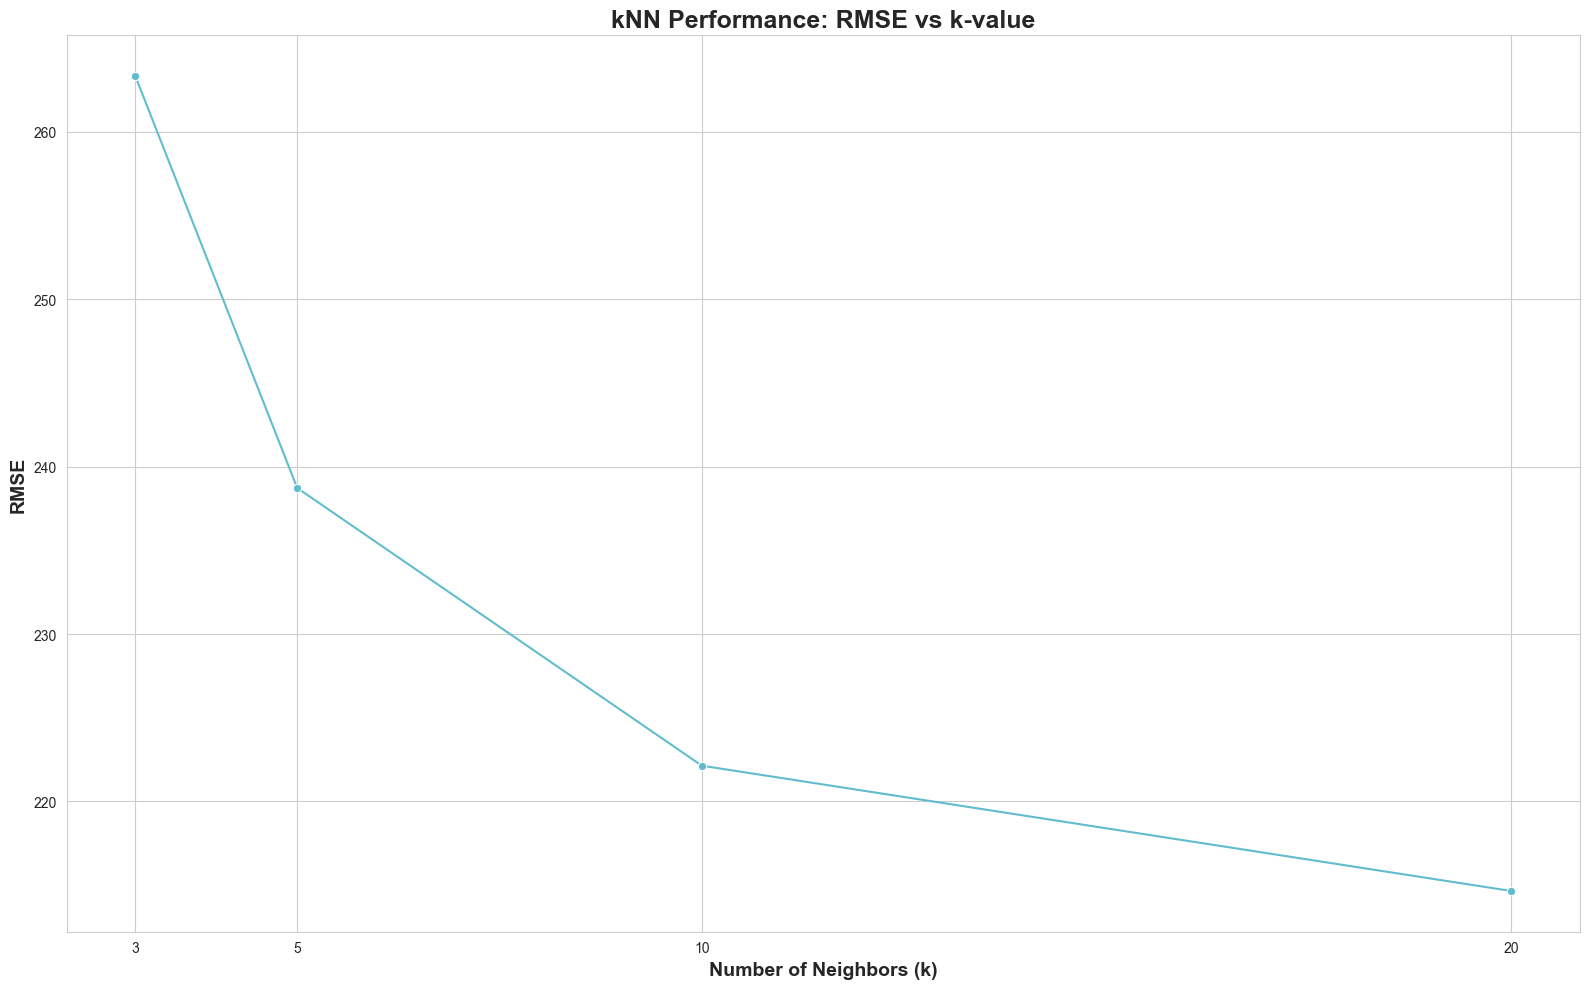

In [12]:
ks = [3, 5, 10, 20]
rmse_values = [results_knn[k][0] for k in ks]

color = sns.color_palette("GnBu", 6)[3]

plt.figure(figsize = (16, 10))
sns.lineplot(x = ks, y = rmse_values, marker = 'o', color = color)

plt.title("kNN Performance: RMSE vs k-value", fontsize = 18, fontweight = "bold")
plt.xlabel("Number of Neighbors (k)", fontsize = 14, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 14, fontweight = "bold")
plt.xticks(ks)
plt.tight_layout()

plt.show()

In [13]:
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

knn_rmse = mean_squared_error(y_test, y_pred_knn)
knn_mae = mean_absolute_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)

print('Mean Squared Error (RMSE):',knn_rmse)
print('Absolute Error Rate (MAE):', knn_mae)
print('R-Squared:', knn_r2)


Mean Squared Error (RMSE): 214.65097733129443
Absolute Error Rate (MAE): 11.42970718998669
R-Squared: 0.2934220339105468


### **5.3 Decision Tree Regressor**

A Decision Tree Regressor was trained using several values of max_depth to control model complexity. Depths of 3, 5, 10, and 20 were evaluated, with max_depth = 10 providing the best balance between underfitting and overfitting. This configuration achieved an RMSE = 218.31, MAE = 11.46, and R-squared = .281, outperforming the Linear Regression baseline and performing comparably to the tuned kNN model.

Feature importance analysis showed that variables such as loudness, energy, danceability, and acousticness contributed most strongly to predicting _**popularity**_. These findings highlight that non-linear splits capture meaningful structure in the dataset, but deeper trees risk overfitting without substantial performance gains.


In [14]:
depths = [3, 5, 10, 20]
results_dt = {}

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=13)
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_dt[d] = (rmse, mae, r2)

results_dt


{3: (245.18138096380815, 12.42080246356696, 0.19292349078368742),
 5: (230.66801646880268, 11.949694149060592, 0.24069789970318867),
 10: (218.30774335056884, 11.460527763343535, 0.28138486394986173),
 20: (322.77414554308007, 13.541644164824964, -0.062492713052467286)}

In [15]:
dt = DecisionTreeRegressor(max_depth = 10)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

dt_rmse = mean_squared_error(y_test, y_pred_dt)
dt_mae = mean_absolute_error(y_test, y_pred_dt)
dt_r2 = r2_score(y_test, y_pred_dt)

print('Mean Squared Error (RMSE):',dt_rmse)
print('Absolute Error Rate (MAE):', dt_mae)
print('R-Squared:', dt_r2)


Mean Squared Error (RMSE): 218.1260742774957
Absolute Error Rate (MAE): 11.458651956700832
R-Squared: 0.2819828736386565


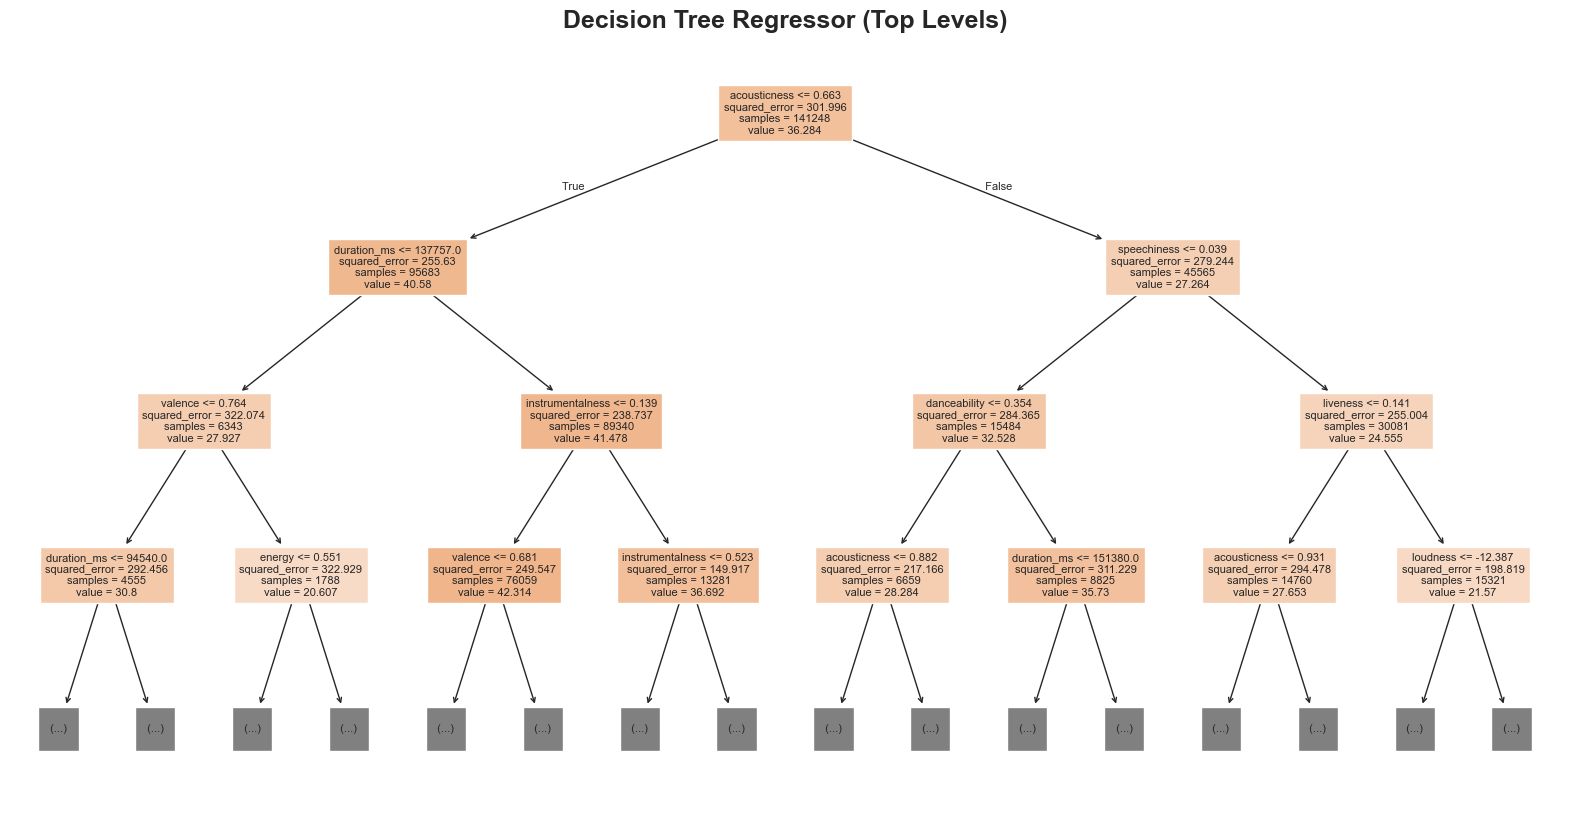

In [16]:
plt.figure(figsize = (20, 10))

plot_tree(dt, feature_names = X_train.columns, filled = True,fontsize = 8, max_depth = 3)

plt.title("Decision Tree Regressor (Top Levels)", fontsize = 18, fontweight = "bold")
plt.show()

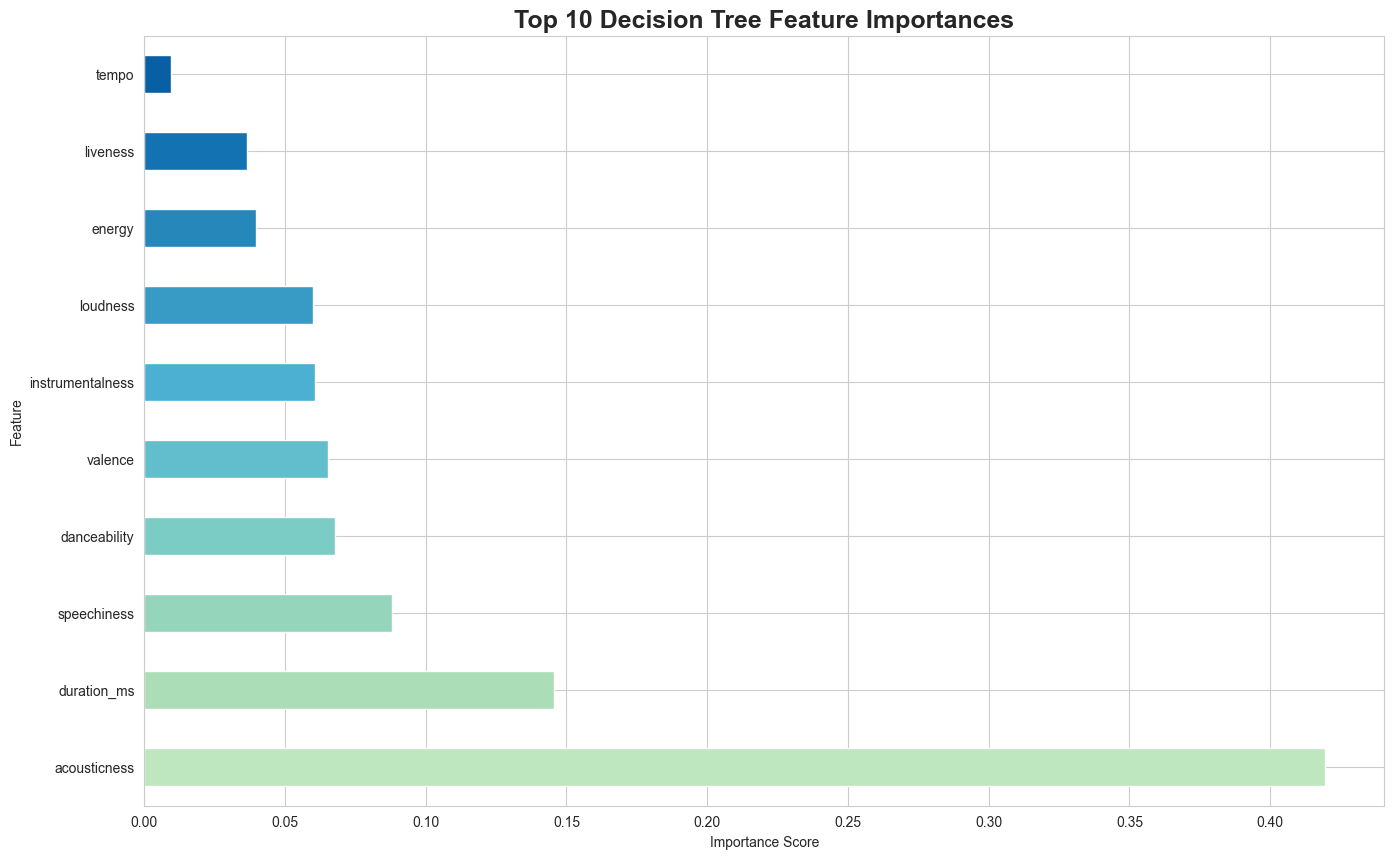

In [17]:
feature_importances = pd.Series(
    dt.feature_importances_,
    index = X_train.columns
).sort_values(ascending = False)

vals = feature_importances.head(10)

feature_importances.head(10).plot(kind = 'barh', figsize = (16, 10), color = plt.cm.GnBu(np.linspace(0.3, 0.9, len(vals))))
plt.title("Top 10 Decision Tree Feature Importances", fontsize = 18, fontweight = "bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
